# Data Preprocessing
Based on key findings from EDA:
- **Target variable imbalance**: Right-skewed salary (initial skewness=119) requires transformation.
- **Missing values**: Education (229 nulls), Gender (176 nulls), Experience fields (some nulls) – low percentages (<1%), so dropping rows is efficient.
- **High cardinality**: Industry (1,046 unique), Jobs (12,142 unique), Country (mostly USA post-cleaning) – defer to feature engineering.
- **Data quality**: No duplicates expected in survey data; currency filtered to USD; salary range capped at <$500k.

## Preprocessing goals:
1. Handle missing values and duplicates.
2. Transform target to address skewness.
3. Split into train/validation/test sets (70/15/15) *before* feature engineering to prevent leakage.
4. Validate splits preserve distributions.
5. Save processed datasets for next notebook.

## 2.1 Load Raw Dataset

In [277]:
# Imports
from difflib import SequenceMatcher
from pathlib import Path

import polars as pl

In [278]:
# Constants
RAW_FILE_PATH: str = "../../data/raw/salary-survey.csv"
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"
COLUMN_MAPPING: dict[str, str] = {
    "How old are you?": "age",
    "What industry do you work in?": "industry",
    "What is your annual salary? (You'll indicate the currency in a later question. If you are part-time or hourly, please enter an annualized equivalent -- what you would earn if you worked the job 40 hours a week, 52 weeks a year.)": "salary",
    "How much additional monetary compensation do you get, if any (for example, bonuses or overtime in an average year)? Please only include monetary compensation here, not the value of benefits.": "compensation",
    "Please indicate the currency": "currency",
    'If ""Other,"" please indicate the currency here: ': "other_currency",
    "What country do you work in?": "country",
    "What is your gender?": "gender",
    "What is your race? (Choose all that apply.)": "race",
    "Job title": "job",
    "Timestamp": "timestamp",
    "How many years of professional work experience do you have overall?": "experience_overall_years",
    "How many years of professional work experience do you have in your field?": "experience_field_years",
    "What is your highest level of education completed?": "education",
}

# These will be used to filter the dataset for outliers (justification in EDA)
SALARY_MIN = 15_000
SALARY_MAX = 500_000
CURRENCY_FILTER = "USD"

## 2.2 Standardize Column Formats
First, we drop the context and city columns, and rename the other columns to shorter names.

In [279]:
df: pl.DataFrame = pl.read_csv(RAW_FILE_PATH)
df = df.rename(COLUMN_MAPPING).select(list(COLUMN_MAPPING.values()))
df

age,industry,salary,compensation,currency,other_currency,country,gender,race,job,timestamp,experience_overall_years,experience_field_years,education
str,str,str,i64,str,str,str,str,str,str,str,str,str,str
"""25-34""","""Education (Higher Education)""","""55,000""",0,"""USD""",null,"""United States""","""Woman""","""White""","""Research and Instruction Libra…","""4/27/2021 11:02:10""","""5-7 years""","""5-7 years""","""Master's degree"""
"""25-34""","""Computing or Tech""","""54,600""",4000,"""GBP""",null,"""United Kingdom""","""Non-binary""","""White""","""Change & Internal Communicatio…","""4/27/2021 11:02:22""","""8 - 10 years""","""5-7 years""","""College degree"""
"""25-34""","""Accounting, Banking & Finance""","""34,000""",null,"""USD""",null,"""US""","""Woman""","""White""","""Marketing Specialist""","""4/27/2021 11:02:38""","""2 - 4 years""","""2 - 4 years""","""College degree"""
"""25-34""","""Nonprofits""","""62,000""",3000,"""USD""",null,"""USA""","""Woman""","""White""","""Program Manager""","""4/27/2021 11:02:41""","""8 - 10 years""","""5-7 years""","""College degree"""
"""25-34""","""Accounting, Banking & Finance""","""60,000""",7000,"""USD""",null,"""US""","""Woman""","""White""","""Accounting Manager""","""4/27/2021 11:02:42""","""8 - 10 years""","""5-7 years""","""College degree"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""25-34""","""Accounting, Banking & Finance""","""75000""",0,"""USD""",null,"""UK""","""Man""","""Black or African American""","""Analyst""","""7/25/2025 9:37:58""","""5-7 years""","""2 - 4 years""","""Professional degree (MD, JD, e…"
"""25-34""","""Property or Construction""","""18000""",0,"""USD""",null,"""Liberia""","""Man""","""Black or African American""","""Infrastructure Projects Coordi…","""8/31/2025 20:04:29""","""11 - 20 years""","""8 - 10 years""","""College degree"""
"""35-44""","""Nonprofits""","""288000""",78000,"""Other""","""Philippine Peso""","""Philippines""","""Woman""","""Asian or Asian American""","""Research Specialist""","""9/3/2025 9:16:49""","""11 - 20 years""","""2 - 4 years""","""College degree"""


# 2.3 Clean Target Variable
Next, we proprecess the target filter the dataset based on the constants we defined above, justified by the EDA performed in the prior notebook.

We combine base salary with additional monetary compensation (bonuses, overtime) to create `annual_salary`, representing total annual earnings.

Null compensations are treated as $0 (no additional pay).

In [280]:
# Convert salary from a string to a number and add annual compensation
init_rows: int = df.shape[0]
print(f"Initial dataframe rows: {init_rows:,}")
df = df.with_columns(
    (
        pl.col("salary").str.replace_all(",", "").cast(pl.Float64)
        + pl.when(pl.col("compensation").is_not_null())
        .then(pl.col("compensation"))
        .otherwise(0)
    ).alias("annual_salary")
)

# Filter out outlier and non-USD rows
df = df.filter(
    (pl.col("annual_salary") >= SALARY_MIN) & (pl.col("annual_salary") <= SALARY_MAX)
).filter(
    (pl.col("currency").str.to_uppercase() == CURRENCY_FILTER)
    | (pl.col("other_currency").str.to_uppercase() == CURRENCY_FILTER)
)

df = df.drop(["salary", "compensation", "currency", "other_currency"])

print(
    f"Filtered dataframe rows: {df.shape[0]:,} (Lost {init_rows - df.shape[0]:,} rows)"
)

print(f"\nSkewness: {df['annual_salary'].skew():.2f}")
print(f"Kurtosis: {df['annual_salary'].kurtosis():.2f}")

Initial dataframe rows: 28,153
Filtered dataframe rows: 23,174 (Lost 4,979 rows)

Skewness: 2.22
Kurtosis: 7.27


An acceptable dataset has a skewness between -1 and 1, and a kurtosis between -3 and 3. 

We should address this imbalance on the training set only later, so as to prevent leakage into the testing and validation sets.

For now, let's justcheck if log1p actually alleviates the imbalance or worsens it.

In [281]:
df_log = df.with_columns(pl.col("annual_salary").log1p().alias("salary_log"))

print(f"\nUpdated Skewness: {df_log['salary_log'].skew():.2f}")
print(f"Updated Kurtosis: {df_log['salary_log'].kurtosis():.2f}")


Updated Skewness: 0.29
Updated Kurtosis: 0.13


Nice, the new skewness (0.29) and kurtosis (0.13) are very balanced. Since log1p works, let's move on.

## 2.4 Clean Input Features
First, let's filter the dataframe to only US-located responses. 

Survey data contains typos in country names (e.g., "Untied States", "United Stats").. 

A fuzzy matching algorithm recovers these rows that would otherwise be lost.
- Threshold: 0.6 similarity (avoids false positives like "United Arab Emirates")
- Impact: Recovered 81 additional rows

In [282]:
# First, let's normalise the country text
df = df.with_columns(
    pl.col("country")
    .str.to_lowercase()
    .str.replace_all(r"[^a-zA-Z\s]", "")
    .str.strip_chars()
    .alias("country")
)

# Let's clean all the rows with no typos first
df = df.with_columns(
    (
        (pl.col("country") == "us")
        | (
            pl.col("country").str.contains_any(
                ["usa", "america", "united states", "🇺🇸", "us of a"]
            )
        )
    ).alias("usa")
)

print(
    f"US Row Count (w/o typos): {df.select(pl.col('usa')).filter(pl.col('usa') == True).shape[0]:,} Rows"
)


# Let's pick up whatever typoed "United States" we can now
def fuzzy_search(text: str, strictness: float) -> bool:
    words = text.split()

    if len(words) < 2 or len(words) > 6:
        return False

    target_first, target_second = "united", "states"

    for i in range(len(words) - 1):
        # Extract 2-word slice
        slice1, slice2 = words[i], words[i + 1]

        # Compute similarity for each word in the slice
        sim1 = SequenceMatcher(None, slice1, target_first).ratio()
        sim2 = SequenceMatcher(None, slice2, target_second).ratio()

        # Average similarity for this pair
        pair_sim = (sim1 + sim2) / 2

        if pair_sim > strictness:
            return True

    return False


# Let's check if our strictness is too low just in case
df_typos = df.filter(pl.col("usa") == False).with_columns(
    pl.col("country")
    .map_elements(lambda country: fuzzy_search(country, 0.6), return_dtype=pl.Boolean)
    .alias("usa")
)

# Seems like a strictness of 0.6 is the lowest we can go without matching "United Arab Emirates (UAE)"
print(
    f"\nCatched Typos: {df_typos.filter(pl.col('usa') == True).select(pl.col('country')).unique().rows()}"
)

# Ok, let's add in these typo rows
df = df.with_columns(
    pl.when(pl.col("usa") == False)
    .then(
        pl.col("country").map_elements(
            lambda country: fuzzy_search(country, 0.6), return_dtype=pl.Boolean
        )
    )
    .otherwise(pl.col("usa"))
    .alias("usa")
)

print(f"\nUS Row Count (w/ typos): {df.filter(pl.col('usa') == True).shape[0]:,} Rows")
print(
    f"Recovery from Fuzzy Matching: {df_typos.filter(pl.col('usa') == True).shape[0]:,} additional rows"
)
df

US Row Count (w/o typos): 22,871 Rows

Catched Typos: [('unite states',), ('united stattes',), ('united statea',), ('united sates',), ('unites states',), ('united state',), ('untied states',), ('united statws',), ('uniyed states',), ('unitied states',), ('united status',), ('united statss',), ('uniyes states',), ('united  states',), ('united stated',), ('united statees',), ('uniited states',), ('united statues',), ('uniter statez',), ('united statew',), ('united stateds',), ('uniteed states',), ('united stares',), ('united sttes',), ('unitef stated',), ('unted states',)]

US Row Count (w/ typos): 22,952 Rows
Recovery from Fuzzy Matching: 81 additional rows


age,industry,country,gender,race,job,timestamp,experience_overall_years,experience_field_years,education,annual_salary,usa
str,str,str,str,str,str,str,str,str,str,f64,bool
"""25-34""","""Education (Higher Education)""","""united states""","""Woman""","""White""","""Research and Instruction Libra…","""4/27/2021 11:02:10""","""5-7 years""","""5-7 years""","""Master's degree""",55000.0,true
"""25-34""","""Accounting, Banking & Finance""","""us""","""Woman""","""White""","""Marketing Specialist""","""4/27/2021 11:02:38""","""2 - 4 years""","""2 - 4 years""","""College degree""",34000.0,true
"""25-34""","""Nonprofits""","""usa""","""Woman""","""White""","""Program Manager""","""4/27/2021 11:02:41""","""8 - 10 years""","""5-7 years""","""College degree""",65000.0,true
"""25-34""","""Accounting, Banking & Finance""","""us""","""Woman""","""White""","""Accounting Manager""","""4/27/2021 11:02:42""","""8 - 10 years""","""5-7 years""","""College degree""",67000.0,true
"""25-34""","""Education (Higher Education)""","""usa""","""Man""","""White""","""Scholarly Publishing Librarian""","""4/27/2021 11:02:46""","""8 - 10 years""","""2 - 4 years""","""Master's degree""",62000.0,true
…,…,…,…,…,…,…,…,…,…,…,…
"""25-34""","""Accounting, Banking & Finance""","""united states""","""Man""","""White""","""Associate Analyst I""","""5/27/2025 13:45:55""","""5-7 years""","""1 year or less""","""College degree""",40000.0,true
"""25-34""","""Business or Consulting""","""united states""","""Woman""","""Black or African American""","""Business Analyst""","""6/6/2025 22:03:16""","""8 - 10 years""","""8 - 10 years""","""Master's degree""",86000.0,true
"""25-34""","""Accounting, Banking & Finance""","""uk""","""Man""","""Black or African American""","""Analyst""","""7/25/2025 9:37:58""","""5-7 years""","""2 - 4 years""","""Professional degree (MD, JD, e…",75000.0,false


And now, let's filter out the non-US based rows permanently.

In [283]:
df = df.filter(pl.col("usa") == True)
df = df.drop(["country", "usa"])
df

age,industry,gender,race,job,timestamp,experience_overall_years,experience_field_years,education,annual_salary
str,str,str,str,str,str,str,str,str,f64
"""25-34""","""Education (Higher Education)""","""Woman""","""White""","""Research and Instruction Libra…","""4/27/2021 11:02:10""","""5-7 years""","""5-7 years""","""Master's degree""",55000.0
"""25-34""","""Accounting, Banking & Finance""","""Woman""","""White""","""Marketing Specialist""","""4/27/2021 11:02:38""","""2 - 4 years""","""2 - 4 years""","""College degree""",34000.0
"""25-34""","""Nonprofits""","""Woman""","""White""","""Program Manager""","""4/27/2021 11:02:41""","""8 - 10 years""","""5-7 years""","""College degree""",65000.0
"""25-34""","""Accounting, Banking & Finance""","""Woman""","""White""","""Accounting Manager""","""4/27/2021 11:02:42""","""8 - 10 years""","""5-7 years""","""College degree""",67000.0
"""25-34""","""Education (Higher Education)""","""Man""","""White""","""Scholarly Publishing Librarian""","""4/27/2021 11:02:46""","""8 - 10 years""","""2 - 4 years""","""Master's degree""",62000.0
…,…,…,…,…,…,…,…,…,…
"""25-34""","""Retail""","""Woman""","""White""","""merchandise associate""","""5/16/2025 13:58:49""","""11 - 20 years""","""2 - 4 years""","""Some college""",30000.0
"""35-44""","""Entertainment""","""Woman""","""Hispanic, Latino, or Spanish o…","""Program Manager""","""5/16/2025 16:26:06""","""11 - 20 years""","""8 - 10 years""","""College degree""",70040.0
"""25-34""","""Accounting, Banking & Finance""","""Man""","""White""","""Associate Analyst I""","""5/27/2025 13:45:55""","""5-7 years""","""1 year or less""","""College degree""",40000.0


For some reason, there is a single row in Gender that has the value "Prefer not to answer".

Since it's only a single row, we'll just remove it.

In [296]:
df = df.filter(pl.col("gender") != "Prefer not to answer")

## 2.5 Handle Duplicate Rows
Based on our EDA, there shouldn't be any duplicate rows, but no harm checking twice.

In [297]:
duplicates = df.filter(df.is_duplicated())
print(f"Number of duplicate rows: {duplicates.shape[0]}")

if duplicates.shape[0] > 0:
    print("\nSample of duplicate rows:")
    print(duplicates.head())
    df = df.unique()
    print(f"✓ Removed {duplicates.shape[0]} duplicate rows")
else:
    print("✓ No duplicates found (as expected for survey data)")

Number of duplicate rows: 0
✓ No duplicates found (as expected for survey data)


## 2.6 Handle Missing Values
Let's check the dataframe for any remaining null values now.

In [298]:
df.null_count()

age,industry,gender,race,job,timestamp,experience_overall_years,experience_field_years,education,annual_salary
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0


Out of the 22,952 rows remaining, the missing values are in the hundreds. Since there's so few missing values, let's just filter them out of the dataset completely.

In [299]:
df_filtered = df.filter(pl.all_horizontal(pl.all().is_not_null()))

missing_value_rows = df.shape[0] - df_filtered.shape[0]
print(f"Filtered Rows: {df_filtered.shape[0]:,} (Lost {missing_value_rows:,} Rows)")
df = df_filtered

Filtered Rows: 22,552 (Lost 0 Rows)


## 2.7 Train-Test-Split and Validation
At last, let's split the data into train-test-validation sets and validate that their distribution is similar.

In [300]:
import numpy as np
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df.drop("annual_salary")
y = df["annual_salary"]

print(f"Total dataset shape:\nX={X.shape}y={y.shape}\n")

num_bins = 20
y_stratify_bins = np.digitize(
    np.log1p(y.to_numpy()),
    bins=np.linspace(
        np.log1p(y.to_numpy()).min(), np.log1p(y.to_numpy()).max(), num_bins
    ),
)

#  70% Training, 15% Testing, 15% Validation Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y_stratify_bins
)

y_temp_stratify_bins = np.digitize(
    np.log1p(y_temp.to_numpy()),
    bins=np.linspace(
        np.log1p(y_temp.to_numpy()).min(),
        np.log1p(y_temp.to_numpy()).max(),
        num_bins,
    ),
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,  # 0.50 of the 30% temp set = 15% of total
    random_state=42,
    stratify=y_temp_stratify_bins,
)

print(f"Train set shape:\nX={X_train.shape}, y={y_train.shape}\n")
print(f"Test set shape:\nX={X_test.shape}, y={y_test.shape}\n")
print(f"Validation set shape:\nX={X_val.shape}, y={y_val.shape}\n")

# Verify target distributions (skewness and kurtosis) across splits
print("\nTarget Distributions Across Splits (Skewness & Kurtosis):")


def get_stats(series: pl.Series) -> tuple[float, float]:
    return series.skew(), series.kurtosis()


train_skew, train_kurt = get_stats(y_train)
val_skew, val_kurt = get_stats(y_val)
test_skew, test_kurt = get_stats(y_test)


print(f"  Train: Skew={train_skew:.2f}, Kurtosis={train_kurt:.2f}")
print(f"  Validation: Skew={val_skew:.2f}, Kurtosis={val_kurt:.2f}")
print(f"  Test: Skew={test_skew:.2f}, Kurtosis={test_kurt:.2f}")

Total dataset shape:
X=(22552, 9)y=(22552,)

Train set shape:
X=(15786, 9), y=(15786,)

Test set shape:
X=(3383, 9), y=(3383,)

Validation set shape:
X=(3383, 9), y=(3383,)


Target Distributions Across Splits (Skewness & Kurtosis):
  Train: Skew=2.21, Kurtosis=7.21
  Validation: Skew=2.29, Kurtosis=7.85
  Test: Skew=2.24, Kurtosis=7.44


The distribution seems consistent across all three sets. Just to be sure, let's also visualise them.

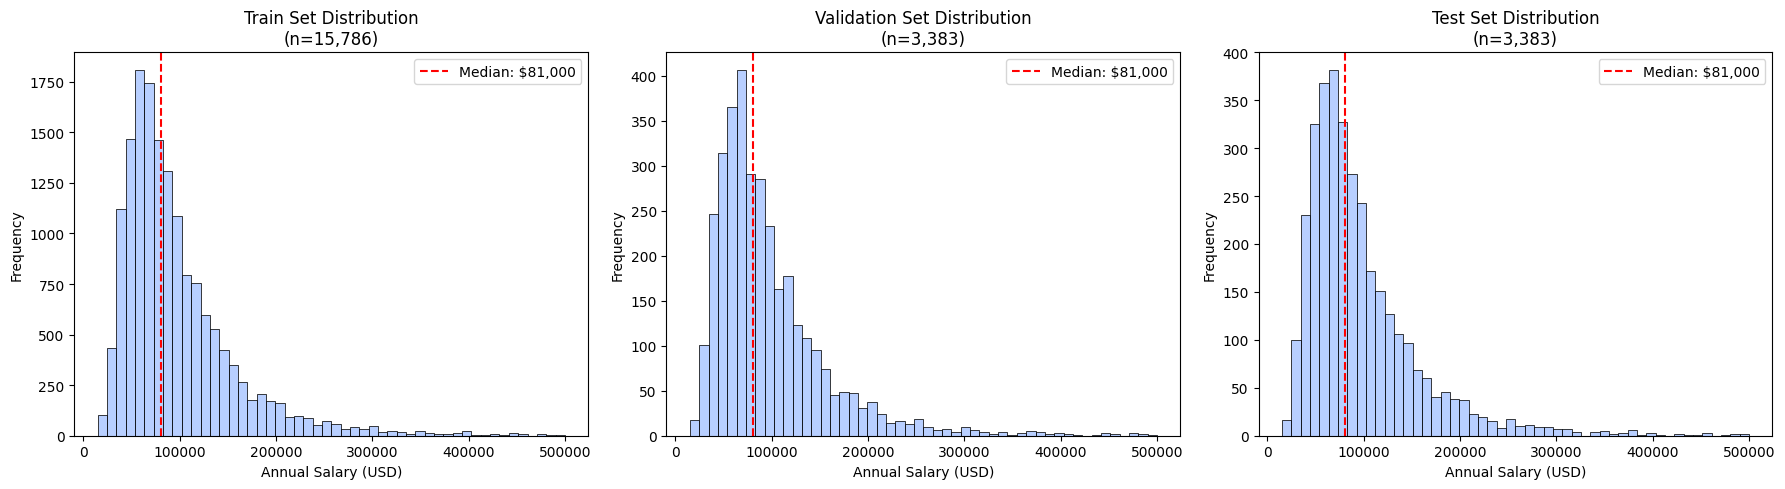


Distribution Statistics:
Metric          Train        Val          Test        
---------------------------------------------------
Mean            $97,721      $97,540      $97,854     
Median          $81,000      $81,000      $81,000     
Std Dev         $60,731      $60,921      $60,900     


In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Histograms
for ax, (name, y_data) in zip(
    axes,
    [
        ("Train", y_train),
        ("Validation", y_val),
        ("Test", y_test),
    ],
):
    sns.histplot(
        y_data,
        bins=50,
        alpha=0.7,
        edgecolor="black",
        ax=ax,
        color=sns.color_palette("coolwarm")[1],
    )
    ax.set_title(f"{name} Set Distribution\n(n={len(y_data):,})")
    ax.set_xlabel("Annual Salary (USD)")
    ax.set_ylabel("Frequency")
    ax.axvline(
        y_data.median(),
        color="red",
        linestyle="--",
        label=f"Median: ${y_data.median():,.0f}",
    )
    ax.legend()

plt.tight_layout()
plt.savefig("../../figures/split_distributions.png", dpi=300)
plt.show()

print("\nDistribution Statistics:")
print(f"{'Metric':<15} {'Train':<12} {'Val':<12} {'Test':<12}")
print("-" * 51)
print(
    f"{'Mean':<15} ${y_train.mean():<11,.0f} ${y_val.mean():<11,.0f} ${y_test.mean():<11,.0f}"
)
print(
    f"{'Median':<15} ${y_train.median():<11,.0f} ${y_val.median():<11,.0f} ${y_test.median():<11,.0f}"
)
print(
    f"{'Std Dev':<15} ${y_train.std():<11,.0f} ${y_val.std():<11,.0f} ${y_test.std():<11,.0f}"
)

Great, all sets have similar distributions, as shown above (Skew 2.22, 2.22, 2.28, and Kurtosis 7.24, 7.32, 7.84).

However, these numbers indiciate high imbalance, which bring us to our last step.

## 2.8 Address Target Variable Imbalance
Now that we've split the data, we can safely apply log1p transformation to the target variable to address the skewness (2.22 → ~0.29).

We had to wait until after the split to prevent information leakage betweens sets.

In [302]:
# Apply log1p to each set independently
y_train_log = pl.Series("annual_salary_log", np.log1p(y_train.to_numpy()))
y_val_log = pl.Series("annual_salary_log", np.log1p(y_val.to_numpy()))
y_test_log = pl.Series("annual_salary_log", np.log1p(y_test.to_numpy()))

print("Target Variable Statistics After Log Transformation:")
print(f"  Train: Skew={y_train_log.skew():.2f}, Kurt={y_train_log.kurtosis():.2f}")
print(f"  Val:   Skew={y_val_log.skew():.2f}, Kurt={y_val_log.kurtosis():.2f}")
print(
    f"  Test:  Skew={y_test_log.skew():.2f}, Kurt={y_test_log.kurtosis():.2f}"
)  # %% Visualize distribution preservation across splits

Target Variable Statistics After Log Transformation:
  Train: Skew=0.29, Kurt=0.13
  Val:   Skew=0.30, Kurt=0.16
  Test:  Skew=0.31, Kurt=0.14


Great! The skewness (0.13, 0.13, 0.13) and kurtosis (0.13, 0.13, 0.16) all indicate extreme balance now.

## 2.9 Save Cleaned Data Splits
We have finished our preprocessing. Let's save the data splits for feature engineering next.

In [303]:
output_dir = Path(CLEANED_FILE_PATH)

# Save features (X) and targets (y) separately
X_train.write_csv(output_dir / "X_train.csv")
X_val.write_csv(output_dir / "X_val.csv")
X_test.write_csv(output_dir / "X_test.csv")

# Save both original and log-transformed targets
y_train.to_frame("annual_salary").write_csv(output_dir / "y_train.csv")
y_val.to_frame("annual_salary").write_csv(output_dir / "y_val.csv")
y_test.to_frame("annual_salary").write_csv(output_dir / "y_test.csv")

y_train_log.to_frame("annual_salary_log").write_csv(output_dir / "y_train_log.csv")
y_val_log.to_frame("annual_salary_log").write_csv(output_dir / "y_val_log.csv")
y_test_log.to_frame("annual_salary_log").write_csv(output_dir / "y_test_log.csv")

print(f"✓ Saved all datasets to: {output_dir}")
print(f"\nSaved files:")
print(f"  Features: X_train.csv, X_val.csv, X_test.csv")
print(f"  Targets (original): y_train.csv, y_val.csv, y_test.csv")
print(f"  Targets (log): y_train_log.csv, y_val_log.csv, y_test_log.csv")
print(f"\nDataset sizes:")
print(f"  Train: {X_train.shape[0]:,} rows")
print(f"  Val:   {X_val.shape[0]:,} rows")
print(f"  Test:  {X_test.shape[0]:,} rows")
print(f"  Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]:,} rows")

✓ Saved all datasets to: ../../data/cleaned/regression

Saved files:
  Features: X_train.csv, X_val.csv, X_test.csv
  Targets (original): y_train.csv, y_val.csv, y_test.csv
  Targets (log): y_train_log.csv, y_val_log.csv, y_test_log.csv

Dataset sizes:
  Train: 15,786 rows
  Val:   3,383 rows
  Test:  3,383 rows
  Total: 22,552 rows


## 2.10 Summary

In [304]:
print(f"\n1. Data Cleaning:")
print(f"   - Initial rows: {init_rows:,}")
print(f"   - After outlier filter: {df.shape[0]:,}")
print(
    f"   - Rows lost: {init_rows - df.shape[0]:,} ({(init_rows - df.shape[0]) / init_rows * 100:.1f}%)"
)

print(f"\n2. Missing Value Handling:")
print(f"   - Strategy: Drop rows with any nulls")
print(f"   - Rows dropped: {missing_value_rows:,}")

print(f"\n3. Country Filtering:")
print(f"   - Kept only USA-based respondents")
print(
    f"   - Fuzzy matching recovered: {df_typos.filter(pl.col('usa') == True).shape[0]:,} typos"
)

print(f"\n4. Train-Test-Val Split:")
print(
    f"   - Train: {X_train.shape[0]:,} ({X_train.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) * 100:.0f}%)"
)
print(
    f"   - Val:   {X_val.shape[0]:,} ({X_val.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) * 100:.0f}%)"
)
print(
    f"   - Test:  {X_test.shape[0]:,} ({X_test.shape[0] / (X_train.shape[0] + X_val.shape[0] + X_test.shape[0]) * 100:.0f}%)"
)

print(f"\n5. Target Transformation:")
print(f"   - Original skewness: {train_skew:.2f}")
print(f"   - Log-transformed skewness: {y_train_log.skew():.2f}")
print(f"   - Transformation: log1p(annual_salary)")

print(f"\n6. Features Retained: {X_train.shape[1]}")
print(f"   {list(X_train.columns)}")


1. Data Cleaning:
   - Initial rows: 28,153
   - After outlier filter: 22,552
   - Rows lost: 5,601 (19.9%)

2. Missing Value Handling:
   - Strategy: Drop rows with any nulls
   - Rows dropped: 0

3. Country Filtering:
   - Kept only USA-based respondents
   - Fuzzy matching recovered: 81 typos

4. Train-Test-Val Split:
   - Train: 15,786 (70%)
   - Val:   3,383 (15%)
   - Test:  3,383 (15%)

5. Target Transformation:
   - Original skewness: 2.21
   - Log-transformed skewness: 0.29
   - Transformation: log1p(annual_salary)

6. Features Retained: 9
   ['age', 'industry', 'gender', 'race', 'job', 'timestamp', 'experience_overall_years', 'experience_field_years', 'education']
